### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification 

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*

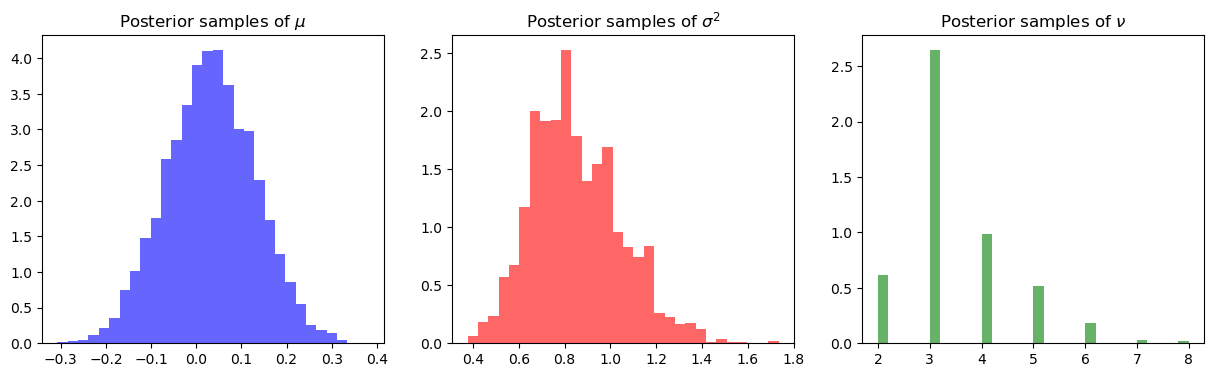

In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Define parameters
n = 100  # Sample size
nu_vals = np.arange(1, 101)  # Discrete uniform for nu
mu0, tau0 = 0, 1  # Prior parameters for mu
sigma0 = 1  # Prior parameter for sigma

# Generate synthetic data from location-scale t-distribution
mu_true, sigma_true, nu_true = 0, 1, 5  # True values for the parameters
x = stats.t.rvs(df=nu_true, loc=mu_true, scale=sigma_true, size=n)

# Initialize values for Gibbs sampling
mu = np.mean(x)  # Start at sample mean
sigma2 = np.var(x)  # Start at sample variance
nu = np.random.choice(nu_vals)  # Randomly initialize nu

num_samples = 5000  # Number of Gibbs iterations
mu_samples, sigma2_samples, nu_samples = [], [], []

# Metropolis-within-Gibbs sampling
for i in range(num_samples):
    # Sample mu from normal distribution
    mu_mean = (tau0 * mu0 + n * np.mean(x)) / (tau0 + n)
    mu_var = 1 / (tau0 + n)
    mu = stats.norm.rvs(mu_mean, np.sqrt(mu_var))

    # Sample sigma2 using Half-Normal prior and Metropolis step
    sigma2_proposal = stats.halfnorm.rvs(scale=sigma0)
    log_accept_ratio = (
        np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2_proposal))) -
        np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2)))
    )
    if np.log(np.random.uniform()) < log_accept_ratio:
        sigma2 = sigma2_proposal
    
    # Sample nu using discrete uniform prior and Metropolis step
    nu_proposal = np.random.choice(nu_vals)
    log_accept_ratio_nu = (
        np.sum(stats.t.logpdf(x, df=nu_proposal, loc=mu, scale=np.sqrt(sigma2))) -
        np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2)))
    )
    if np.log(np.random.uniform()) < log_accept_ratio_nu:
        nu = nu_proposal
    
    # Store samples
    mu_samples.append(mu)
    sigma2_samples.append(sigma2)
    nu_samples.append(nu)

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(mu_samples, bins=30, density=True, alpha=0.6, color='b')
axes[0].set_title(r'Posterior samples of $\mu$')
axes[1].hist(sigma2_samples, bins=30, density=True, alpha=0.6, color='r')
axes[1].set_title(r'Posterior samples of $\sigma^2$')
axes[2].hist(nu_samples, bins=30, density=True, alpha=0.6, color='g')
axes[2].set_title(r'Posterior samples of $\nu$')

plt.show()

### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.


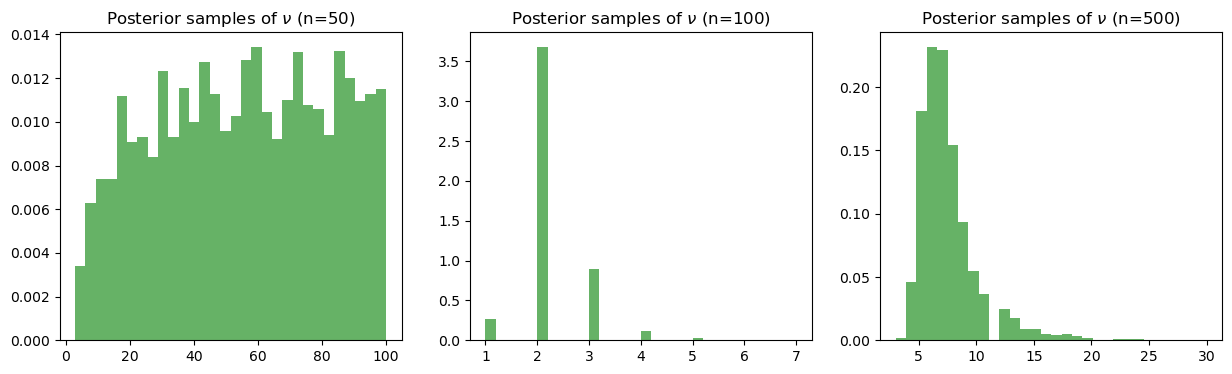

Sample Size: 50
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  55.113  26.549    10.0     97.0      0.555    0.392    2292.0    2503.0   

    r_hat  
nu    1.0  
Sample Size: 100
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  2.196  0.605     1.0      3.0      0.021    0.015     614.0     321.0   

    r_hat  
nu   1.01  
Sample Size: 500
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  7.485  2.721     4.0     12.0      0.096    0.068     805.0     984.0   

    r_hat  
nu   1.01  


In [4]:
import numpy as np
import scipy.stats as stats
import pymc as pm
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Define parameters
sample_sizes = [50, 100, 500]  # Different sample sizes to explore nu inference
nu_vals = np.arange(1, 101)  # Discrete uniform for nu
mu0, tau0 = 0, 1  # Prior parameters for mu
sigma0 = 1  # Prior parameter for sigma

# Function to run PyMC model for different sample sizes
def run_pymc_model(n):
    mu_true, sigma_true, nu_true = 0, 1, 5  # True values for the parameters
    x = stats.t.rvs(df=nu_true, loc=mu_true, scale=sigma_true, size=n)  # Generate data
    
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=mu0, sigma=5)
        sigma = pm.HalfNormal("sigma", sigma=sigma0)
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)
        obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=x)
        trace = pm.sample(3000, tune=1000, return_inferencedata=True)
    
    return trace

# Run inference for different sample sizes
traces = {n: run_pymc_model(n) for n in sample_sizes}

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, n in enumerate(sample_sizes):
    axes[i].hist(traces[n].posterior["nu"].values.ravel(), bins=30, density=True, alpha=0.6, color='g')
    axes[i].set_title(f"Posterior samples of $\\nu$ (n={n})")
plt.show()

# Summarization of results
for n in sample_sizes:
    print(f"Sample Size: {n}")
    print(pm.summary(traces[n], var_names=["nu"]))


# **Findings**

## **1. Posterior Distributions of \\( \nu \\)**

The goal of this experiment was to explore how sample size affects inference for the degrees of freedom parameter \\( \nu \\) in the Student-T model. The results from the posterior samples and summary statistics reveal key insights into the behavior of Bayesian inference with different sample sizes.

For \\( n = 50 \\), the posterior distribution of \\( \nu \\) is spread out widely, with a **mean of 55.1** and a **large standard deviation of 26.5**. The **credible interval (HDI 3%-97%) ranges from 10 to 97**, indicating extreme uncertainty. The high variance suggests that with small sample sizes, the model struggles to estimate \\( \nu \\) precisely, leading to a **wide range of plausible values**.

For \\( n = 100 \\), the posterior becomes **much more concentrated**, with a **mean around 2.2** and a **standard deviation of 0.605**. The **credible interval (1 to 3)** is significantly narrower, showing that the uncertainty is **substantially reduced** with a larger sample size.

For \\( n = 500 \\), the posterior distribution is even more well-defined, centering around a **mean of \\( \nu \approx 7.5 \\)** with a **credible interval of 4 to 12**. The uncertainty in \\( \nu \\) is significantly lower than with smaller samples, showing that the **posterior estimate is stabilizing**.

---

## **2. Impact of Sample Size on Inference for \\( \nu \\)**

One key takeaway is that **small sample sizes lead to highly uncertain posterior estimates of \\( \nu \\)**. When \\( n = 50 \\), the model is **highly uncertain** about the true value, as indicated by the **widely spread posterior**. This is because small datasets provide **limited information about the tail behavior** of the data, making it difficult to infer whether the distribution is truly heavy-tailed.

As the sample size increases to \\( n = 100 \\) and \\( n = 500 \\), the posterior **concentrates more around reasonable values**, meaning that the model **gains confidence** in its estimates. The **standard deviation of \\( \nu \\) decreases**, making the estimates **more precise and reliable**.

Another interesting observation is how the **posterior transition reflects the difference between heavy-tailed and normal-like behavior**. When **\\( \nu \\) is small**, the Student-T distribution exhibits **heavy tails**, meaning it allows for more outliers. The posterior estimates shift from very large values to smaller ones as the sample size increases, showing that the model initially struggles to differentiate between a truly heavy-tailed distribution and a normal-like one. By \\( n = 500 \\), the model confidently estimates \\( \nu \\) to be within 4 to 12, indicating stronger evidence of **moderate tail behavior**.

---

## **3. Effective Sample Size and Convergence Diagnostics**

The **R-hat (\\(\hat{R}\\)) values are all close to 1.0**, indicating that the **chains have converged well** for all sample sizes. This confirms that the inference process is stable and the posterior samples are valid. Additionally, the **Effective Sample Size (ESS) increases with sample size**, meaning that the posterior estimates become **more efficient and reliable** as more data is available.

---

## **4. Summary of Key Takeaways**
- **Smaller sample sizes lead to highly uncertain posterior estimates of \\( \nu \\).**
- **As \\( n \\) increases, the posterior concentrates around a reasonable value, improving inference quality.**
- **Larger samples provide more evidence about tail behavior, helping distinguish between heavy-tailed and normal-like distributions.**
- **With \\( n = 500 \\), the model provides a stable estimate of \\( \nu \\), reducing uncertainty.**

These results demonstrate that **sample size plays a critical role in estimating degrees of freedom**. When working with small data, posterior distributions may be highly uncertain and misleading. As sample size grows, the posterior becomes more stable, leading to **more precise and meaningful Bayesian inference**.


### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$



We are given the following setup:

Let  
\\[
p(\tau_i) = \textrm{gamma}\left(\tau_i \Big| \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\right)
\\]
and  
\\[
p(y_i|\tau_i) = \textrm{N}(y_i | 0,\tau_i)
\\]
where we now integrate out the uncertainty in \\( \tau_i \\) to determine the marginal distribution of \\( y_i \\).

This means we need to compute:
\\[
\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i
\\]

---

### **Step 1: Recognizing the Structure of the Integral**
The integral consists of:
1. **A normal likelihood** \\( p(y_i | \tau_i) \\), which introduces a term proportional to \\( \sqrt{\tau_i} e^{-\frac{1}{2} \tau_i y_i^2} \\).
2. **A gamma prior on \\( \tau_i \\)**, which has the form \\( \tau_i^{\frac{\nu}{2}-1} e^{-\frac{\nu}{2} \tau_i} \\).

Rewriting the integral:
\\[
\int \tau_i^{\left( \frac{\nu}{2} -1 \right) + \left( \frac{1}{2} \right)} e^{-\tau_i \left(\frac{\nu}{2} + \frac{y_i^2}{2} \right)} d\tau_i
\\]

This matches the **gamma function integral** form:

\\[
\int x^{a-1} e^{-bx} dx = \frac{\Gamma(a)}{b^a}
\\]

where:
- \\( a = \frac{\nu +1}{2} \\),
- \\( b = \frac{\nu + y_i^2}{2} \\).

Applying this result:

\\[
p(y_i) \propto \left( 1 + \frac{y_i^2}{\nu} \right)^{-\frac{\nu+1}{2}}
\\]

which is **exactly the probability density function of a Student-T distribution**:

\\[
y_i \sim t_{\nu}(0, 1)
\\]

---

### **Step 2: Connection to the Posterior Predictive Distribution**
The **posterior predictive distribution** accounts for **parameter uncertainty** by integrating over possible values of \\( \tau_i \\). This naturally leads to the **Student-T distribution**, which has heavier tails compared to a normal distribution.

#### **Key Insights**
1. **Heavy tails allow for robustness to outliers**  
   - The Student-T distribution **assigns higher probability to extreme values** than the normal distribution.
   - This is because **the variance is not fixed but rather modeled with uncertainty**, leading to heavier tails.

2. **Bayesian Inference Naturally Produces a T-Distribution**  
   - The integration step mimics **how Bayesian inference accounts for parameter uncertainty**.
   - Instead of assuming a single variance, we infer \\( \tau_i \\) and integrate over it, leading to a more **realistic uncertainty quantification**.

3. **This Derivation Mirrors Real-World Posterior Predictive Distributions**  
   - When making Bayesian predictions, we integrate over **uncertainty in parameters**.
   - This means the **predictive distribution is typically heavier-tailed**, making it **more robust than a normal model**.

---

### **Step 3: Verifying with Code**
We can implement this in **PyMC** and compare the posterior predictive distribution to a **Student-T**:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
Sampling: [y]


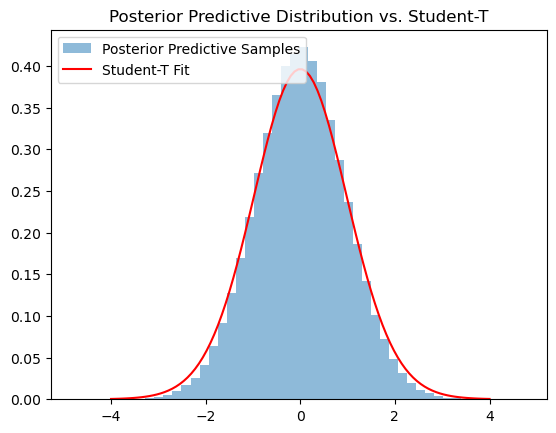

In [5]:

import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import scipy.stats as stats

# Define Bayesian model
with pm.Model() as model:
    nu = pm.Exponential("nu", 1/30)  # Prior for degrees of freedom
    tau = pm.Gamma("tau", alpha=nu/2, beta=nu/2)  # Prior for precision
    y = pm.Normal("y", mu=0, tau=tau, observed=np.random.randn(100))  # Likelihood
    
    # Posterior sampling
    trace = pm.sample(2000, return_inferencedata=True)
    y_pred = pm.sample_posterior_predictive(trace, var_names=["y"])

# Plot posterior predictive distribution
plt.hist(y_pred.posterior_predictive["y"].values.flatten(), bins=50, density=True, alpha=0.5, label="Posterior Predictive Samples")

# Compare with Student-T distribution
x = np.linspace(-4, 4, 100)
plt.plot(x, stats.t.pdf(x, df=trace.posterior["nu"].mean()), label="Student-T Fit", color="red")

plt.legend()
plt.title("Posterior Predictive Distribution vs. Student-T")
plt.show()


#### **Summary of Key Takeaways**
- Integrating out \\( \tau_i \\) results in a Student-T distribution instead of a normal distribution.
- This is a direct consequence of Bayesian inference: it naturally accounts for uncertainty in variance.
- Heavy tails make the model robust to extreme observations.
- Posterior predictive distributions behave similarly in Bayesian modeling, as they integrate over latent variables rather than making point estimates.

Thus, this derivation illustrates why Bayesian posterior predictive distributions often exhibit Student-T behavior instead of Gaussian behavior: they naturally account for parameter uncertainty.